In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [2]:
# neural_decoder_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\predict_proba_by_session.parquet"

# neural_decoder_path=r'D:\decoding_results_from_CO\task_vs_spont_2026-01-06\task_predict_proba_by_session_10_units.parquet'
neural_decoder_path=r"D:\decoding_results_from_CO\prestim_only_1_5sec_10_units_2026-01-26\task_predict_proba_by_session_10_units.parquet"

neural_decoder_results=pd.read_parquet(neural_decoder_path)

In [3]:
face_decoder_path='s3://aind-scratch-data/dynamic-routing/face-decoding/results/v268_3/'
face_decoder_results=pl.read_parquet(face_decoder_path)

In [78]:
face_decoder_filtered=face_decoder_results.filter(
    pl.col('time_aligned_to').eq('quiescent_stop_time'),
    # pl.col('model_label').eq('facial_features'),
    # pl.col('model_label').eq('facemap'),
    pl.col('is_all_trials'),
).to_pandas()

In [5]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.parquet"
session_table=pl.read_parquet(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [6]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()#.to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect()#.to_pandas()

In [7]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """

    if sel_unit_subsample_size=='all':
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [8]:
# average some areas together per session:

simplfied_structure_grouping = {
    'VIS': ['VISp', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor'],
    'AUD': ['AUDp', 'AUDv', 'AUDd', 'AUDpo'],
    'AI': ['AIp', 'AIv', 'AId'],
    'HPF': ['CA1', 'CA2', 'CA3', 'DG', 'ENTl', 'ENTm', 'PAR', 'POST', 'PRE', 'SUB', 'ProS'],
    'OLF': ['OLF','AON','AOB','MOB','TT','DP','PIR'],
    'THALsm': ['VAL','VM','VPL','VPLpc','VPM','MGd','MGv','MGm','LGd'],
    'THALpm': ['LP','PO','POL','SGN','Eth', #
               'AV','AMd','AMv','AD','IAM','IAD','LD', #
               'IMD','MD','SMT','PR', #
               'PVT','PT','RE','Xi', #
               'RH','PCN','CM','CL','PF','PIL', #
               'RT', #
               'IGL','IntG','LGv','SubG', #
               'MH','LH' #
               ],
    'AMY': ['BLAp','CEAm'],
    'BG': ['GP','GPe','GPi','SNr','SNc','VTA'],
    'LS': ['LSc','LSr','LSv'],
}


In [9]:
# for each session, get the average predict proba for each structure in the simplified_structure_grouping, and delete the original structure-session row
predict_proba_pd=neural_decoder_results.copy()

predict_proba_pd=predict_proba_pd[~predict_proba_pd['structure'].str.contains('SCzo|SCop|SCsg|SCiw|SCig|SCdw|SCdg|ECT1|ECT2/3|ECT4|ECT5|ECT6a|ECT6b')]

sel_bin_center=-0.75
# sel_bin_center=0.155
new_predict_proba_pd = []

#round bin_center to 3 decimal places to avoid floating point issues
predict_proba_pd['bin_center']=predict_proba_pd['bin_center'].round(3)

#loop through each session
for sel_session in dr_session_list:
    print(f'Processing session {sel_session}')
    
    #get the table for the session
    predict_proba_pd_session=predict_proba_pd.query(f'session_id=="{sel_session}" and bin_center=={sel_bin_center}').reset_index(drop=True)

    #loop through each structure in the simplified_structure_grouping
    for new_structure, old_structures in simplfied_structure_grouping.items():
        if len(old_structures) > 1:
            #get the rows for the old structures
            old_structure_rows = predict_proba_pd_session.query(f'structure in {old_structures}')

            #check if length of predict_proba for each rows match
            if old_structure_rows['predict_proba'].apply(len).nunique() > 1:
                print(f'Warning: predict_proba lengths do not match for session {sel_session} and structures {old_structures}. Skipping...')
                continue

            if not old_structure_rows.empty:
                new_structure_row = {
                    'session_id': sel_session,
                    'structure': new_structure,
                    'unit_subsample_size': old_structure_rows['unit_subsample_size'].iloc[0],
                    'bin_center': old_structure_rows['bin_center'].iloc[0],
                    'time_aligned_to': old_structure_rows['time_aligned_to'].iloc[0],
                    'balanced_accuracy_test': old_structure_rows['balanced_accuracy_test'].mean(),
                    # 'total_n_units': old_structure_rows['total_n_units'].iloc[0],
                    'predict_proba': [old_structure_rows['predict_proba'].mean()],
                    'trial_index': [old_structure_rows['trial_index'].iloc[0]],
                    'is_vis_rewarded': [old_structure_rows['is_vis_rewarded'].iloc[0]],
                    'stim_name': [old_structure_rows['stim_name'].iloc[0]],
                    'is_response': [old_structure_rows['is_response'].iloc[0]],
                }

                predict_proba_pd_session = pd.concat([predict_proba_pd_session, pd.DataFrame(new_structure_row)], axis=0, ignore_index=True)
                
                #drop the old structure rows from the new_predict_proba_pd
                predict_proba_pd_session = predict_proba_pd_session.query(f'structure not in {old_structures}')


        else:
            #if only one old structure, just rename it to the new structure
            predict_proba_pd_session.loc[predict_proba_pd_session['session_id'] == sel_session, 'structure'] = old_structures[0]

    #update the new_predict_proba_pd with the session results
    # new_predict_proba_pd = pd.concat([new_predict_proba_pd, predict_proba_pd_session], axis=0, ignore_index=True)
    new_predict_proba_pd.append(predict_proba_pd_session)
    
    
new_predict_proba_pd = pd.concat(new_predict_proba_pd, axis=0, ignore_index=True)

Processing session 626791_2022-08-15
Processing session 626791_2022-08-16
Processing session 636766_2023-01-23
Processing session 636766_2023-01-24
Processing session 636766_2023-01-25
Processing session 636766_2023-01-26
Processing session 644864_2023-01-30
Processing session 644864_2023-01-31
Processing session 644864_2023-02-02
Processing session 644866_2023-02-08
Processing session 644866_2023-02-09
Processing session 644866_2023-02-10
Processing session 649943_2023-02-13
Processing session 649943_2023-02-14
Processing session 649943_2023-02-15
Processing session 649943_2023-02-16
Processing session 644867_2023-02-20
Processing session 644867_2023-02-22
Processing session 644867_2023-02-23
Processing session 660023_2023-08-09
Processing session 666986_2023-08-14
Processing session 666986_2023-08-15
Processing session 666986_2023-08-17
Processing session 662892_2023-08-22
Processing session 662892_2023-08-23
Processing session 662892_2023-08-24
Processing session 668755_2023-08-28
P

In [150]:
# get predict proba from each structure in this session (at selected time bin), correct it, append to the trials table, correlate across structures

sel_time_bin=-0.75
correction='flip_aud' #'subtract_mean' or 'flip_aud' or 'none'
excl_instruction_trials=True
sel_unit_subsample_size=10
sel_time_aligned_to='stim_start_time'
# sel_time_aligned_to='response_or_reward_time'

unrewarded_targets_only=False

data_table=new_predict_proba_pd.copy() #simplified structures
# data_table=predict_proba_pd.copy() #original with all structures
data_table['bin_center']=data_table['bin_center'].round(3)

sel_face_time_bin=-0.75
face_data_table=face_decoder_filtered.copy()

predict_proba_corr_dict={
    'session_id':[],
    'time_bin':[],
    'structure_0':[],
    'structure_1':[],
    'r':[],
    'p':[],
}

for sel_session in session_table.filter(pl.col('project')=="DynamicRouting",pl.col('is_production'),
                                        pl.col('issues').eq([]))['session_id'].unique().to_list():
# for sel_session in session_table.filter(pl.col('project')=="Templeton",pl.col('issues').eq(""))['session_id'].unique().to_list():

    session_structures=data_table.query(f'session_id=="{sel_session}"')['structure'].unique()
    session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index')

    if len(session_structures)==0:
        continue

    if sel_session in face_data_table['session_id'].values:
        session_structures=np.concatenate([session_structures,np.array(['facemap','facial_features'])])
    if (
        session_trials['block_index'].n_unique() == 1
        and not (
            session_table.filter(
                pl.col('session_id') == session_trials['session_id'][0], 
                pl.col('is_templeton'),
            )
        ).is_empty()
    ):
        print(f'Adding dummy context labels for Templeton session {sel_session}')
        session_trials = (
            session_trials
            .with_columns(
                pl.col('start_time').sub(pl.col('start_time').min().over('session_id')).truediv(10*60).floor().clip(0, 5).alias('block_index')
                # short 7th block will sometimes be present: merge into 6th with clip
            )
            .with_columns(
                pl.when(pl.col('block_index').mod(2).eq(random.choice([0, 1])))
                .then(pl.lit('vis'))
                .otherwise(pl.lit('aud'))
                .alias('rewarded_modality')
            )
            .sort('trial_index')
        )

    session_trials = session_trials.to_pandas()

    for sel_structure in session_structures:
        if sel_structure=='facemap' or sel_structure=='facial_features':
            structure_results=face_data_table.query('session_id==@sel_session and model_label==@sel_structure')
            structure_results['bin_center']=structure_results['bin_center'].round(3)
            predict_proba=structure_results.query(f'bin_center==({sel_face_time_bin})')['predict_proba'].values[0]
            trial_indices=structure_results.query(f'bin_center==({sel_face_time_bin})')['trial_indices'].values[0]
        else:
            structure_results=get_session_structure_results(data_table, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
            structure_results['bin_center']=structure_results['bin_center'].round(3)
            predict_proba=structure_results.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]
            trial_indices=structure_results.query(f'bin_center==({sel_time_bin})')['trial_index'].values[0]

        #limit trial indices; assumes all results use the same trials
        session_structure_trials=session_trials.query('trial_index in @trial_indices').sort_values(by='trial_index')

        if len(predict_proba)!=len(session_structure_trials):
            print(f"Skipping {sel_session}, {sel_structure} due to mismatch in number of trials between trials and predict_proba")
            predict_proba=np.array([np.nan]*len(session_structure_trials))

        temp_combined_trials=session_structure_trials.copy()
        temp_combined_trials['predict_proba']=predict_proba

        corrected_predict_proba = []
        for bb in temp_combined_trials['block_index'].unique():
            block_trials=temp_combined_trials.query(f'block_index=={bb}')
            if correction=='flip_aud':
                if block_trials['rewarded_modality'].values[0]=='vis':
                    corrected_predict_proba.append(block_trials['predict_proba'].values)
                elif block_trials['rewarded_modality'].values[0]=='aud':
                    corrected_predict_proba.append(1 - block_trials['predict_proba'].values)
            elif correction=='subtract_mean':
                corrected_predict_proba.append(block_trials['predict_proba'].values - np.nanmean(block_trials['predict_proba'].values))
            elif correction=='none':
                corrected_predict_proba.append(block_trials['predict_proba'].values)

        corrected_predict_proba = np.concatenate(corrected_predict_proba)

        session_structure_trials[f'{sel_structure}_predict_proba']=corrected_predict_proba

        session_trials=session_trials.merge(
            session_structure_trials[['trial_index', f'{sel_structure}_predict_proba']],
            on='trial_index',
            how='left',
        )

    # add a "behavior" column
    # -1 for response to non-rewarded target
    # 1 for no response to non-rewarded target
    # 0 for other stimuli
    session_trials['choice_predict_proba']=np.nan
    #false alarms
    session_trials.loc[
        (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=-1
    #correct rejects
    session_trials.loc[
        (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=1
    # # #hits
    # session_trials.loc[
    #     (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
    #     (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
    #     ,'choice_predict_proba']=1
    # #misses
    # session_trials.loc[
    #     (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
    #     (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
    #     ,'choice_predict_proba']=-1

    if unrewarded_targets_only:
        session_trials=session_trials.query('is_target and ~is_rewarded')

    if excl_instruction_trials:
        session_trials=session_trials.query('~is_instruction').reset_index(drop=True)

    for col0 in session_trials.filter(like='predict_proba').columns:
        for col1 in session_trials.filter(like='predict_proba').columns:
            if col0!=col1:
                if (np.sum(np.isnan(session_trials[col0]))>0)|(np.sum(np.isnan(session_trials[col1]))>0):
                    notnanidx=~np.isnan(session_trials[col0])&~np.isnan(session_trials[col1])
                    if sum(notnanidx)==0:
                        r=np.nan
                        p=np.nan
                    else:
                        r,p=stats.pearsonr(session_trials[col0][notnanidx], session_trials[col1][notnanidx])
                else:
                    r,p=stats.pearsonr(session_trials[col0], session_trials[col1])
                # print(f"{col0} vs {col1}: r={r:.3f}, p={p:.3e}")
                predict_proba_corr_dict['session_id'].append(sel_session)
                predict_proba_corr_dict['time_bin'].append(sel_time_bin)
                predict_proba_corr_dict['structure_0'].append(col0.replace('_predict_proba',''))
                predict_proba_corr_dict['structure_1'].append(col1.replace('_predict_proba',''))
                predict_proba_corr_dict['r'].append(r)
                predict_proba_corr_dict['p'].append(p)

predict_proba_corr_df=pd.DataFrame(predict_proba_corr_dict)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20320\696593366.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_results['bin_center']=structure_results['bin_center'].round(3)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20320\696593366.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_results['bin_center']=structure_results['bin_center'].round(3)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20320\696593366.py:70: SettingWithCopyWarning: 
A value is trying to be 

In [137]:
# session_trials.query('is_target and ~is_rewarded')[['rewarded_modality','stim_name','is_response']].head(50)

In [120]:
# structure_results.query(f'bin_center==({sel_time_bin})')

In [151]:
predict_proba_corr_df['structure_0'].unique()

array(['MOp', 'MOs', 'VIS', 'HPF', 'facemap', 'facial_features', 'choice',
       'ACAd', 'ACAv', 'CP', 'ILA', 'PL', 'RSPd', 'RSPv', 'SCm', 'SCs',
       'SSp', 'TEa', 'STR', 'AUD', 'THALsm', 'THALpm', 'ACB', 'APN',
       'FRP', 'ORBl', 'ORBvl', 'AI', 'PP', 'PoT', 'BG', 'MRN', 'RSPagl',
       'LS', 'MB', 'PAL', 'RN', 'SEZ', 'ORBm', 'BST', 'ZI', 'PPN', 'OT',
       'PAG', 'root', 'SSs', 'VISC', 'GU', 'NB', 'TTd', 'VL', 'ECT',
       'PERI', 'ICe', 'TH', 'SF', 'TRS', 'CLA', 'VISrl', 'lot', 'VPMpc',
       'DT', 'SAG', 'LA', 'CTXsp', 'MPT', 'PPT', 'out of brain', 'HY',
       'AMY', 'SH', 'NOT', 'IG'], dtype=object)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20320\805892161.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_results['bin_center']=face_results['bin_center'].round(3)


Text(0.5, 1.0, '664851_2023-11-13 ACAd predict_proba at -0.75s\nstruct,choice r = 0.328, p = 3.635e-04\nstruct,face r = 0.562, p = 1.862e-42')

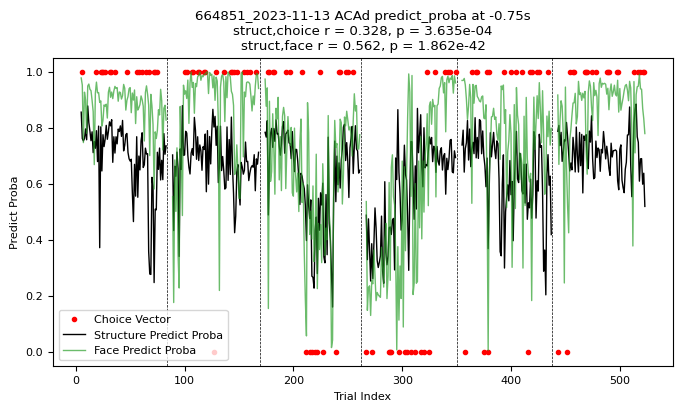

In [166]:
#plot example of predict proba and choice on same plot

sel_session="664851_2023-11-13"
sel_structure="ACAd"

correction='flip_aud' #'subtract_mean' or 'flip_aud' or 'none'
excl_instruction_trials=True
sel_time_bin=-0.75
sel_unit_subsample_size=10
sel_time_aligned_to='stim_start_time'
# sel_time_aligned_to='response_or_reward_time'

unrewarded_targets_only=False

sel_face_model='facial_features'
sel_face_time_bin=-0.75

structure_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
structure_results['bin_center']=structure_results['bin_center'].round(3)
predict_proba=structure_results.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]
predict_proba_trial_indices=structure_results.query(f'bin_center==({sel_time_bin})')['trial_index'].values[0]
session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index').to_pandas()
block_switches=session_trials.query('is_block_switch').index.values
session_trials=session_trials.query('trial_index in @predict_proba_trial_indices').copy()

face_results=face_data_table.query('session_id==@sel_session and model_label==@sel_face_model')
face_results['bin_center']=face_results['bin_center'].round(3)
face_predict_proba=face_results.query(f'bin_center==({sel_face_time_bin})')['predict_proba'].values[0]

temp_combined_trials=session_trials.copy()
temp_combined_trials['predict_proba']=predict_proba
temp_combined_trials['face_predict_proba']=face_predict_proba

corrected_predict_proba = []
corrected_face_predict_proba = []
for bb in temp_combined_trials['block_index'].unique():
    block_trials=temp_combined_trials.query(f'block_index=={bb}')
    if correction=='flip_aud':
        if block_trials['rewarded_modality'].values[0]=='vis':
            corrected_predict_proba.append(block_trials['predict_proba'].values)
            corrected_face_predict_proba.append(block_trials['face_predict_proba'].values)
        elif block_trials['rewarded_modality'].values[0]=='aud':
            corrected_predict_proba.append(1 - block_trials['predict_proba'].values)
            corrected_face_predict_proba.append(1-block_trials['face_predict_proba'].values)
    elif correction=='subtract_mean':
        corrected_predict_proba.append(block_trials['predict_proba'].values - np.nanmean(block_trials['predict_proba'].values))
        corrected_face_predict_proba.append(block_trials['face_predict_proba'].values - np.nanmean(block_trials['face_predict_proba'].values))
    elif correction=='none':
        corrected_predict_proba.append(block_trials['predict_proba'].values)
        corrected_face_predict_proba.append(block_trials['face_predict_proba'].values)

corrected_predict_proba = np.concatenate(corrected_predict_proba)
corrected_face_predict_proba = np.concatenate(corrected_face_predict_proba)

session_trials[f'{sel_structure}_predict_proba']=corrected_predict_proba
session_trials[f'face_predict_proba']=corrected_face_predict_proba

# add a "behavior" column
# -1 for response to non-rewarded target
# 1 for no response to non-rewarded target
session_trials['choice_predict_proba']=np.nan
#false alarms
session_trials.loc[
    (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
    (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
    ,'choice_predict_proba']=-1
#correct rejects
session_trials.loc[
    (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
    (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
    ,'choice_predict_proba']=1
# # #hits
# session_trials.loc[
#     (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
#     (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
#     ,'choice_predict_proba']=1
# #misses
# session_trials.loc[
#     (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
#     (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
#     ,'choice_predict_proba']=-1

if unrewarded_targets_only:
    session_trials=session_trials.query('is_target and ~is_rewarded')

if excl_instruction_trials:
    instruction_trials=session_trials.query('is_instruction').index.values
    session_trials.loc[instruction_trials,'choice_predict_proba']=np.nan
    session_trials.loc[instruction_trials,f'{sel_structure}_predict_proba']=np.nan
    session_trials.loc[instruction_trials,f'face_predict_proba']=np.nan

nanind=~np.isnan(session_trials['choice_predict_proba'])&~np.isnan(session_trials[f'{sel_structure}_predict_proba'])
r,p=stats.pearsonr(session_trials['choice_predict_proba'][nanind], session_trials[f'{sel_structure}_predict_proba'][nanind])

nanind=~np.isnan(session_trials['face_predict_proba'])&~np.isnan(session_trials[f'{sel_structure}_predict_proba'])
rstructface,pstructface=stats.pearsonr(session_trials['face_predict_proba'][nanind], session_trials[f'{sel_structure}_predict_proba'][nanind])

#plot predict_proba and choice on same plot
fig,ax=plt.subplots(1,1,figsize=(8,4))
for bb in block_switches:
    ax.axvline(x=bb, color='black', linestyle='--', linewidth=0.5)
ax.plot(session_trials['trial_index'], (session_trials['choice_predict_proba']+1)/2, 'r.', label='Choice Vector')
ax.plot(session_trials['trial_index'], session_trials[f'{sel_structure}_predict_proba'], color='k', linewidth=1, label='Structure Predict Proba')
ax.plot(session_trials['trial_index'], session_trials[f'face_predict_proba'], color='tab:green', linewidth=1, alpha=0.7, label='Face Predict Proba')
ax.set_xlabel('Trial Index')
ax.set_ylabel('Predict Proba')
ax.legend()
ax.set_title(f"{sel_session} {sel_structure} predict_proba at {sel_time_bin}s\nstruct,choice r = {r:.3f}, p = {p:.3e}\nstruct,face r = {rstructface:.3f}, p = {pstructface:.3e}")

In [153]:
#compute mean correlation across sessions for each structure pair

unique_combos=predict_proba_corr_df[['structure_0','structure_1']].drop_duplicates().reset_index(drop=True)

mean_corr=unique_combos.copy()
mean_corr['mean_r']=np.nan
mean_corr['n_sessions']=0
for rr in range(len(unique_combos)):
    sel_structure_0=unique_combos.loc[rr,'structure_0']
    sel_structure_1=unique_combos.loc[rr,'structure_1']
    temp_df=predict_proba_corr_df.query(f'structure_0==@sel_structure_0 and structure_1==@sel_structure_1')
    mean_corr.loc[rr,'mean_r']=temp_df['r'].mean()
    mean_corr.loc[rr,'n_sessions']=len(temp_df)


In [154]:
custom_incl_structures=True

custom_incl_structures_list=[
    'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOs', 'MOp', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS',
    'APN', 'MRN', 'SCm', 'SCs',
    'CP', 'BG', 'LS',
    'HPF', 
    'THALpm', 'THALsm',
    'facemap',
    'facial_features',
    'choice',
]

unique_structures=predict_proba_corr_df['structure_0'].sort_values().unique()

# unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
#                                                                  'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
#                                                                  'fiber tracts', 'scwm', 'VL', 'V3', 'V4','choice'])]
unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
                                                                 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
                                                                 'fiber tracts', 'scwm', 'VL', 'V3', 'V4'])]

combo_value_counts=predict_proba_corr_df[['structure_0','structure_1']].value_counts()

if custom_incl_structures:
    incl_structures=custom_incl_structures_list
else:
    incl_structures=[]
    for st in unique_structures:
        if (predict_proba_corr_df[['structure_0','structure_1']].value_counts()[st]>=4).sum()>=20:
            incl_structures.append(st)

    incl_structures=np.sort(incl_structures)



#build correlation matrix from this dataframe
corr_matrix=np.full((len(incl_structures), len(incl_structures)), np.nan)
for rr, sel_structure_0 in enumerate(incl_structures):
    for cc, sel_structure_1 in enumerate(incl_structures):
        if sel_structure_0==sel_structure_1:
            corr_matrix[rr,cc]=np.nan
        else:
            temp_df=predict_proba_corr_df.query(f'structure_0=="{sel_structure_0}" and structure_1=="{sel_structure_1}"')
            #only save if at least 3 sessions
            if len(temp_df)>=3:
                corr_matrix[rr,cc]=temp_df['r'].mean()

# corr_matrix[np.isnan(corr_matrix)]=np.nanmean(corr_matrix)

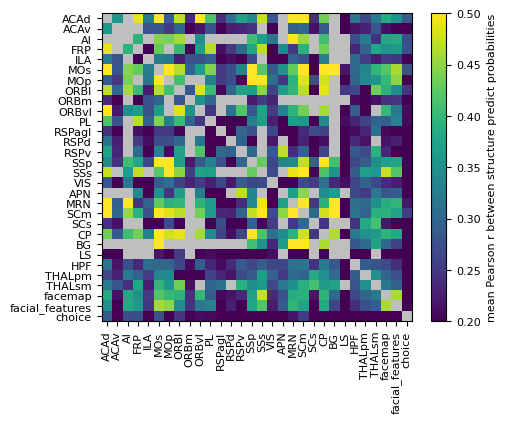

In [155]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.2, vmax=0.5, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')

In [156]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix

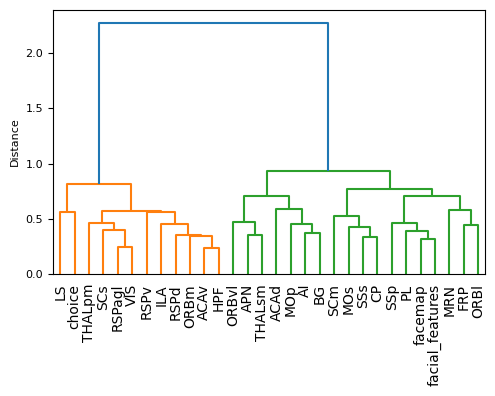

In [157]:
from sklearn.cluster import AgglomerativeClustering

fig,ax=plt.subplots(1,1,figsize=(5,4),sharey=True)

temp_corr_matrix=corr_matrix.copy()

# #optional normalize each row
# temp_corr_matrix[temp_corr_matrix==1]=np.nan
# for rr in range(temp_corr_matrix.shape[0]):
#     norm_row=temp_corr_matrix[rr,:]-np.nanmean(temp_corr_matrix[rr,:])
#     norm_row=norm_row/np.nanstd(norm_row)
#     temp_corr_matrix[rr,:]=norm_row

#hierarchical clustering
clustering = AgglomerativeClustering(
    n_clusters=2,
    metric='euclidean',
    linkage='ward',
    compute_distances=True,
)

naninds=np.isnan(temp_corr_matrix)
temp_corr_matrix[naninds]=np.nanmedian(temp_corr_matrix[temp_corr_matrix!=1])

clustering.fit(temp_corr_matrix)

idx = np.argsort(clustering.labels_)

sort_idx = idx

linkage_matrix=plot_dendrogram(clustering,labels=incl_structures,ax=ax)#, truncate_mode="level", p=3)
ax.set_ylabel('Distance')
# ax.set_title(f'Dendrogram of {epoch} predict proba')
ax.tick_params(axis='x', rotation=90)

fig.tight_layout()

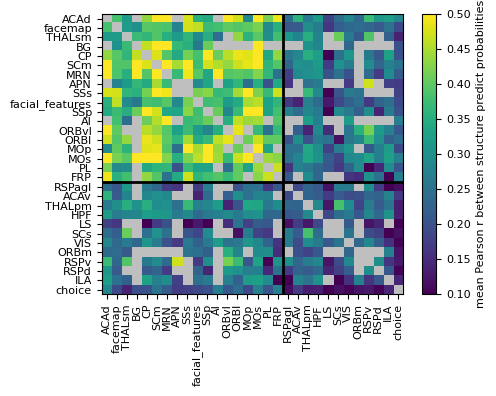

In [158]:
vmin=0.1
vmax=0.5
sel_sort_idx=sort_idx
masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
    
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(np.abs(masked_array[sel_sort_idx][:,sel_sort_idx]), aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), np.array(incl_structures)[sel_sort_idx], rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), np.array(incl_structures)[sel_sort_idx])

cluster_borders = np.where(np.diff(np.sort(clustering.labels_)) != 0)[0] + 0.5

for xx in cluster_borders:
    ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')
# fig.suptitle(f'correlations clustered by {sort_str} activity')
fig.tight_layout()

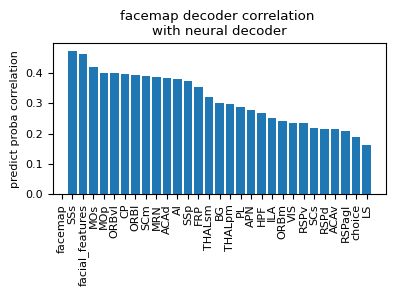

In [159]:
#plot just face row
fig,ax=plt.subplots(1,1,figsize=(4,3))

sel_row=np.where(np.array(incl_structures)=='facemap')[0]
row_sort_ind=np.fliplr(np.argsort(corr_matrix[sel_row,:]))

ax.bar(np.arange(len(incl_structures)),corr_matrix[sel_row,row_sort_ind][0])
ax.set_xticks(np.arange(len(incl_structures)))
ax.set_xticklabels(np.array(incl_structures)[row_sort_ind][0],rotation=90)

ax.set_ylabel('predict proba correlation')
ax.set_title('facemap decoder correlation \nwith neural decoder')

fig.tight_layout()



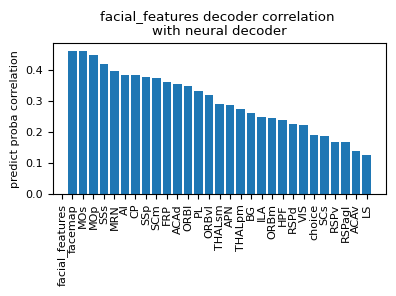

In [160]:
fig,ax=plt.subplots(1,1,figsize=(4,3))

sel_row=np.where(np.array(incl_structures)=='facial_features')[0]
row_sort_ind=np.fliplr(np.argsort(corr_matrix[sel_row,:]))

ax.bar(np.arange(len(incl_structures)),corr_matrix[sel_row,row_sort_ind][0])
ax.set_xticks(np.arange(len(incl_structures)))
ax.set_xticklabels(np.array(incl_structures)[row_sort_ind][0],rotation=90)

ax.set_ylabel('predict proba correlation')
ax.set_title('facial_features decoder correlation \nwith neural decoder')

fig.tight_layout()

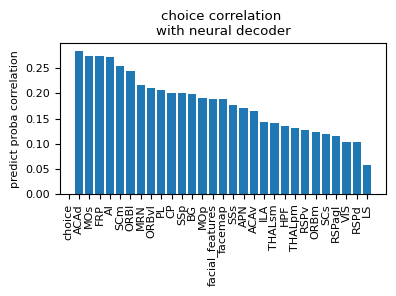

In [161]:
#plot just face row
fig,ax=plt.subplots(1,1,figsize=(4,3))

sel_row=np.where(np.array(incl_structures)=='choice')[0]
row_sort_ind=np.fliplr(np.argsort(corr_matrix[sel_row,:]))

ax.bar(np.arange(len(incl_structures)),corr_matrix[sel_row,row_sort_ind][0])
ax.set_xticks(np.arange(len(incl_structures)))
ax.set_xticklabels(np.array(incl_structures)[row_sort_ind][0],rotation=90)

ax.set_ylabel('predict proba correlation')
ax.set_title('choice correlation \nwith neural decoder')

fig.tight_layout()



In [162]:
# incl_structures=='face'
# np.arange(len(incl_structures))
# corr_matrix[sel_row,row_sort_ind][0]
np.array(incl_structures)[row_sort_ind]

array([['choice', 'ACAd', 'MOs', 'FRP', 'AI', 'SCm', 'ORBl', 'MRN',
        'ORBvl', 'PL', 'CP', 'SSp', 'BG', 'MOp', 'facial_features',
        'facemap', 'SSs', 'APN', 'ACAv', 'ILA', 'THALsm', 'HPF',
        'THALpm', 'RSPv', 'ORBm', 'SCs', 'RSPagl', 'VIS', 'RSPd', 'LS']],
      dtype='<U15')

In [163]:
# try with different unit results??
